In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# runs MALA for LJ7 in 2D
beta = 5 # temperature T = 0.2

# V = 4*sum_(i < j) [rij^{-12} - r^{-6}]
def LJpot(x): # Lennard-Jones potential, x is the position of each particles
    Na = np.size(x,axis = 1) # x has shape [2,7] 
    r2 = np.zeros((Na,Na)) # matrix of distances squared
    for k in range(Na):
        r2[k,:] = (x[0,:]-x[0,k])**2 + (x[1,:]-x[1,k])**2
        r2[k,k] = 1
    er6 = np.divide(np.ones_like(r2),r2**3) 
    L = (er6-1)*er6
    V = 2*np.sum(L) 
    return V

#dV/dx_i = 4*sum_{i\neq j}(-12r_{ij}^{-13} + 6r_{ij}^{-7})*(x_i/r_{ij})
def LJgrad(x):
    Na = np.size(x,axis = 1)
    r2 = np.zeros((Na,Na)) # matrix of distances squared
    for k in range(Na):
        r2[k,:] = (x[0,:]-x[0,k])**2 + (x[1,:]-x[1,k])**2
        r2[k,k] = 1
    r6 = r2**3
    L = -6*np.divide((2*np.divide(np.ones_like(r2),r6)-1),(r2*r6)) # use r2 as variable instead of r
    g = np.zeros_like(x)
    for k in range(Na):
        Lk = L[:,k]
        g[0,k] = np.sum((x[0,k] - x[0,:])*Lk)
        g[1,k] = np.sum((x[1,k] - x[1,:])*Lk)
    g = 4*g 
    return g

xmin = -2.5
xmax = 2.5
ymin = -2.5
ymax = 2.5
bbox = np.array([[xmin,xmax],[ymin,ymax]]) 


In [29]:
# MALA time step
# x = current position
# y = proposed position
# pi(x), pi(y) = pdf at x and y
# pi(x) = Z^{-1}exp(-beta*V(x)), pi(y) = Z^{-1}exp(-beta*V(y))
# q(x-->y) = transition pdf from x to y
# q(y-->x) = transition pdf from y to x
# y = x - dt*grad V(x) + w, where w ~ N(0,(2*dt/beta) I), I is d-by-d identity matrix
# hence 
# q(x-->y) = Z1^{-1} exp( - beta||w||^2/(4*dt) )
# q(y-->x) = Z1^{-1} exp( - beta||x-y+dt*grad V(y)||^2/(4*dt) )
# acceptance ratio: alpha = pi(y)*q(y-->x)/[pi(x)*q(x-->y)]
# alpha = exp(-beta*{V(y)-V(x) +[ ||x-y+dt*grad V(y)||^2 - ||w||^2 ]/(4*dt) } )
# accept move with probability min{alpha,1}
def MALAstep(x,pot_x,grad_x,fpot,fgrad,beta,dt,std):
    # std = sqrt(2*dt/beta)    
    w = np.random.normal(0.0,std,np.shape(x))
    y = x - dt*grad_x + w
    pot_y = fpot(y)
    grad_y = fgrad(y)
    qxy =  np.sum(w**2)  #||w||^2
    qyx = np.sum((x - y + dt*grad_y)**2) # ||x-y+dt*grad V(y)||
    alpha = np.exp(-beta*(pot_y-pot_x+(qyx-qxy)*0.25/dt))
    if alpha < 1: # accept move # are we actually mean when alpha >= 1?
        x = y
        pot_x = pot_y
        grad_x = grad_y
        # print("ACCEPT: alpha = ",alpha)
    else:    
        eta = np.random.uniform(0.0,1.0,(1,))
        if eta < alpha: # accept move 
            x = y
            pot_x = pot_y
            grad_x = grad_y
            # print("ACCEPT: alpha = ",alpha," eta = ",eta)
        else:
            print("REJECT: alpha = ",alpha," eta = ",eta)
    return x,pot_x,grad_x    

LJpot(x) =  -11.398213316380577


Text(0, 0.5, 'Potential energy')

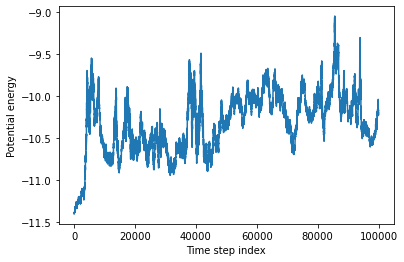

In [30]:
# initial configuration
rstar = np.power(2.0,1/6) # the optimal LJ distance
aux = 0.5*np.sqrt(3)
x = rstar*np.array([[-1.5,-0.5,0.5,1.5,-1.0,0.0,1.0],[0.0,0.0,0.0,0.0,aux,aux,aux]]) # trapezoid
pot_x = LJpot(x)
print("LJpot(x) = ",pot_x)
grad_x = LJgrad(x)

# time step
dt = 1e-6
std = np.sqrt(2*dt/beta)
Nsteps = 100000
LJpotdata = np.zeros((Nsteps+1,))
LJpotdata[0] = pot_x

for j in range(Nsteps):
    x,pot_x,grad_x = MALAstep(x,pot_x,grad_x,LJpot,LJgrad,beta,dt,std)
    LJpotdata[j+1] = pot_x
    
plt.plot(LJpotdata)    
plt.xlabel('Time step index')
plt.ylabel('Potential energy')



